# USDA Soil Texture Plot + Your Samples

1. Plots **USDA soil texture classes** (using `mpltern`).
2. Reads your sample data from a **CSV** (and optionally **XLSX** later).
3. Plots each sample on the ternary diagram.
4. Computes and plots the **centroid** (the mean Sand/Silt/Clay composition).
5. Prints the **USDA texture class** for each sample and for the centroid.

> **Important:** Each sample must have Sand + Silt + Clay ≈ 100.

If you’re missing any of them:

```bash
pip install mpltern pandas openpyxl
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from matplotlib._cm import _Set3_data
from matplotlib.path import Path
from mpltern.datasets import soil_texture_classes
import itertools


## Plot USDA soil texture classes

mpltern: https://mpltern.readthedocs.io/en/develop/gallery/miscellaneous/soil_texture.html

In [2]:
def calculate_polygon_centroid(vertices: np.ndarray) -> np.ndarray:
    """
    Calculate the centroid of a 2D polygon.

    This is used for labeling the USDA class polygons.
    https://en.wikipedia.org/wiki/Centroid#Of_a_polygon

    Parameters
    ----------
    vertices : (n, 2) np.ndarray
        Polygon vertices in 2D (x, y).

    Returns
    -------
    centroid : (2, ) np.ndarray
        Centroid of the polygon (x, y).
    """
    roll0 = np.roll(vertices, 0, axis=0)
    roll1 = np.roll(vertices, -1, axis=0)
    cross = np.cross(roll0, roll1)
    area = 0.5 * np.sum(cross)
    return np.sum((roll0 + roll1) * cross[:, None], axis=0) / (6.0 * area)


def plot_soil_texture_classes(ax):
    """
    Plot USDA soil texture classes and return polygon Paths.

    Returns
    -------
    dict
        Mapping of {class_name: matplotlib.path.Path} in *projected* (x, y) data coordinates.
    """
    classes = soil_texture_classes
    class_paths = {}

    for (key, value), color in zip(classes.items(), _Set3_data):
        tn0, tn1, tn2 = np.array(value).T
        patch = ax.fill(tn0, tn1, tn2, ec='k', fc=color, alpha=0.6, zorder=2.1)
        # patch = ax.fill(tn0, tn1, tn2, ec='k', fc="white", alpha=0.6, zorder=2.1)

        # Label placement: centroid of the drawn polygon in 2D
        poly_xy = patch[0].get_xy()
        centroid_xy = calculate_polygon_centroid(poly_xy)

        label = key[::-1].replace(' ', '\n', 1)[::-1].capitalize()
        ax.text(centroid_xy[0], centroid_xy[1], label, ha='center', va='center', transform=ax.transData, alpha=1.0, zorder=2.2)

        # Save a Path for classification
        class_paths[key] = Path(poly_xy)

    # Axis formatting (same as original)
    ax.taxis.set_major_locator(MultipleLocator(10.0))
    ax.laxis.set_major_locator(MultipleLocator(10.0))
    ax.raxis.set_major_locator(MultipleLocator(10.0))

    ax.taxis.set_minor_locator(AutoMinorLocator(2))
    ax.laxis.set_minor_locator(AutoMinorLocator(2))
    ax.raxis.set_minor_locator(AutoMinorLocator(2))

    ax.grid(which='both')
    ax.taxis.set_ticks_position('tick2')
    ax.laxis.set_ticks_position('tick2')
    ax.raxis.set_ticks_position('tick2')

    # Labeling consistent with common USDA triangle convention
    ax.set_tlabel('Clay (%)')
    ax.set_llabel('Sand (%)')
    ax.set_rlabel('Silt (%)')

    return class_paths


## Normalize your samples so Sand + Silt + Clay = 100

Field / lab data often has rounding or may be recorded as fractions.
This function makes your samples safe to plot and classify.


In [3]:
def normalize_to_100(sand, silt, clay):
    """
    Normalize Sand/Silt/Clay so each row sums to 100.

    Accepts lists, numpy arrays, or pandas Series.

    Parameters
    ----------
    sand, silt, clay : array-like
        Percent values (or any proportional values). Each row/sample will be scaled.

    Returns
    -------
    sand_n, silt_n, clay_n : np.ndarray
        Normalized arrays (each row sums to 100).
    """
    sand = np.asarray(sand, dtype=float)
    silt = np.asarray(silt, dtype=float)
    clay = np.asarray(clay, dtype=float)
    total = sand + silt + clay
    return sand/total*100.0, silt/total*100.0, clay/total*100.0


## Classify a sample into a USDA texture class

Classify by checking which USDA polygon contains your sample point.


In [4]:
def ternary_point_to_xy(ax, clay, sand, silt):
    """
    Convert a ternary point (Clay, Sand, Silt) to projected (x, y).
    """
    coll = ax.scatter([clay], [sand], [silt], s=0.1, alpha=0.0)
    xy = coll.get_offsets()[0]
    coll.remove()
    return xy


def classify_sample(ax, class_paths, sand, silt, clay):
    """
    Return the USDA texture class name for one sample.

    Parameters
    ----------
    sand, silt, clay : float
        Percent composition. Should sum to 100 (approximately).

    Returns
    -------
    str
        Class name (e.g., 'sandy loam'). If no polygon matches, returns 'unclassified'.
    """
    xy = ternary_point_to_xy(ax, clay, sand, silt)
    for class_name, path in class_paths.items():
        if path.contains_point(xy):
            return class_name
    return 'unclassified'


## Plot samples + centroid (mean composition)


In [5]:
def plot_samples_and_centroid(
    ax,
    sand,
    silt,
    clay,
    sample_labels=None,
    label="Samples",
    marker="o",
    size=45,
    zorder=2.6,
    plot_centroid=False,  # Plotting Centroid
    centroid_label=None,
    centroid_size=220,
):
    """Plot a set of samples (and optionally their centroid) on a ternary diagram.

    Notes
    -----
    This notebook uses the common USDA ternary convention:

    - t-axis = Clay (%)
    - l-axis = Sand (%)
    - r-axis = Silt (%)
    - ternary_sum = 100

    Parameters
    ----------
    ax : mpltern axis
        A ternary axis created with projection='ternary'.
    sand, silt, clay : array-like
        Sample compositions (percent or proportional values).
    sample_labels : list[str] or None
        Optional text labels for each sample (e.g., SampleName).
    label : str
        Legend label for the sample group.
    marker : str
        Matplotlib marker style.
    size : float
        Marker size.
    zorder : float
        Draw order (higher = on top).
    plot_centroid : bool
        If True, also plot a star at the centroid (mean composition).
    centroid_label : str or None
        Legend label for the centroid star. If None and plot_centroid=True, defaults to f"{label} centroid".
    centroid_size : float
        Size of the centroid star marker.

    Returns
    -------
    tuple
        (sand_c, silt_c, clay_c) centroid (mean) values.
    """
    sand, silt, clay = normalize_to_100(sand, silt, clay)
    sources = sorted(df[source_col].dropna().unique())
    cmap = plt.get_cmap("tab10")  # or "tab20" if you have lots of sources
    source_color = {src: cmap(i % cmap.N) for i, src in enumerate(sources)}
    # Plot points (mpltern expects (t, l, r) -> here (Clay, Sand, Silt))
    ax.scatter(
        clay, sand, silt,
        s=size,
        marker=marker,
        color=[source_color[src]],
        edgecolors="k",
        linewidths=0.7,
        zorder=zorder,
        label=label,
    )

    # Optional per-point labels
    if sample_labels is not None:
        for cl, sa, sl, name in zip(clay, sand, silt, sample_labels):
            ax.text(
                cl, sa, sl,
                str(name),
                fontsize=8,
                ha="left",
                va="bottom",
                zorder=zorder + 0.1,
                bbox=dict(boxstyle="round,pad=0.15", facecolor="white", alpha=0.5, edgecolor="none"),
            )

    # Centroid (mean)
    sand_c = float(np.mean(sand))
    silt_c = float(np.mean(silt))
    clay_c = float(np.mean(clay))

    if plot_centroid:
        if centroid_label is None:
            centroid_label = f"{label} centroid"
        ax.scatter(
            [clay_c], [sand_c], [silt_c],
            s=centroid_size,
            marker="*",
            edgecolors="k",
            linewidths=1.2,
            zorder=zorder + 0.3,
            label=centroid_label,
        )

    return sand_c, silt_c, clay_c


def plot_samples_grouped_by_source(ax, df, source_col="Source", label_col="SampleName", plot_point_labels=False):
    """Plot samples grouped by source (e.g., Field vs Lab), returning centroids.

    The plot will have one scatter layer per source, each with a legend entry.
    Centroids are computed for printing and (by default) only the **overall** centroid is plotted.

    Parameters
    ----------
    ax : mpltern axis
        Ternary axis.
    df : pandas.DataFrame
        Must contain columns Sand, Silt, Clay. Optionally contains `source_col` and `label_col`.
    source_col : str
        Column name indicating source/category for grouping.
    label_col : str
        Column used for per-point text labels.
    plot_point_labels : bool
        If True, label each point with df[label_col]. Can get cluttered for many samples.

    Returns
    -------
    dict
        Dictionary mapping:
        - 'overall': (sand_c, silt_c, clay_c)
        - each source value: (sand_c, silt_c, clay_c) for that subset
    """
    if source_col not in df.columns:
        # Infer from SampleName prefix before '-' or '_'
        if "SampleName" in df.columns:
            inferred = (
                df["SampleName"]
                .astype(str)
                .str.split(r"[-_]", n=1, expand=True)[0]
                .replace("", "Unknown")
            )
            df = df.copy()
            df[source_col] = inferred
        else:
            df = df.copy()
            df[source_col] = "All"

    # Marker cycle for different groups
    # markers = itertools.cycle(["o", "s", "^", "D", "P", "X", "v", "<", ">"])
    markers = itertools.cycle(["o"])

    centroids = {}

    # Plot each group (points only)
    for src in df[source_col].dropna().unique():
        sub = df[df[source_col] == src]
        marker = next(markers)

        labels = sub[label_col] if (plot_point_labels and label_col in sub.columns) else None

        sand_c, silt_c, clay_c = plot_samples_and_centroid(
            ax,
            sub["Sand"], sub["Silt"], sub["Clay"],
            sample_labels=labels,
            label=str(src),
            marker=marker,
            size=45,
            zorder=2.6,
            plot_centroid=False, # Plotting Centroid
        )
        centroids[str(src)] = (sand_c, silt_c, clay_c)

    return centroids


## Read your data file (CSV now, XLSX later)

This notebook can read either:

- **CSV**: `pd.read_csv(...)`
- **Excel** (`.xlsx` / `.xls`): `pd.read_excel(...)` *(typically needs `openpyxl` installed)*

### Required columns
At minimum, your file must include:

- `Sand`, `Silt`, `Clay`

### Grouping by source (Field vs Lab)
If your file includes a column named **`Source`** (recommended), the notebook will:

- split samples by `Source` (e.g., `Field`, `Lab`)
- plot each source as its **own scatter layer**
- add a **legend entry** for each source

If you *don’t* have a `Source` column, the notebook will try to infer it from `SampleName` by taking the prefix before `-` or `_` (e.g., `Field-01`, `Lab_02`).

## Run the workflow

1. Read your data (`.csv` or `.xlsx`)
2. Plot USDA texture classes
3. Plot samples grouped by source + overall centroid (mean)
4. Print USDA classification for each sample and the centroid (and per-source centroids)


/tmp/ipykernel_15754/2916457296.py:20: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  cross = np.cross(roll0, roll1)


NameError: name 'df' is not defined

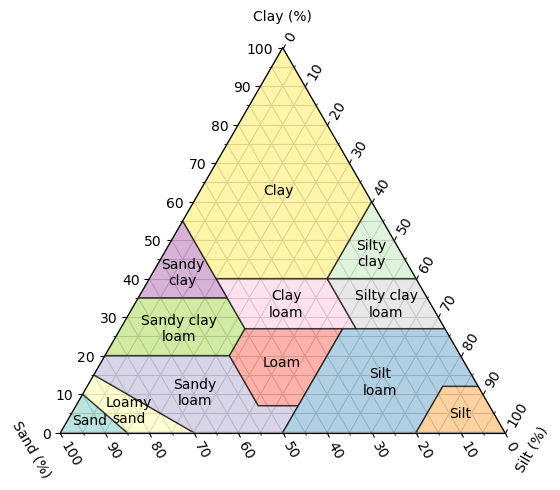

In [6]:
def read_soil_file(path):
    """Read a soil data file (.csv or .xlsx) into a DataFrame."""
    path = str(path)
    if path.lower().endswith(".csv"):
        return pd.read_csv(path)
    if path.lower().endswith((".xlsx", ".xls")):
        return pd.read_excel(path)
    raise ValueError("Unsupported file type. Use .csv or .xlsx")


def main(data_path="my_soils.xlsx", title=None, source_col="Source", plot_point_labels=False):
    """Run USDA texture plotting + classification, grouping points by source.

    Parameters
    ----------
    data_path : str
        Path to .csv or .xlsx file containing Sand/Silt/Clay.
    title : str or None
        Title text for the plot.
    source_col : str
        Column name to group by (e.g., 'Source' with values Field/Lab).
    plot_point_labels : bool
        If True, label each point with SampleName (can get cluttered).
    """
    # Read samples
    df = read_soil_file(data_path)

    # Basic checks
    required = {"Sand", "Silt", "Clay"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}. Need Sand, Silt, Clay.")

    full_title = f"USDA Soil Texture: {title}" if title else "USDA Soil Texture"

    # Create plot
    plt.figure(figsize=(10, 5))
    ax = plt.subplot(projection="ternary", ternary_sum=100.0)

    # USDA polygons + Paths for classification
    class_paths = plot_soil_texture_classes(ax)

    # Plot samples grouped by source + centroids
    centroids = plot_samples_grouped_by_source(
        ax,
        df,
        source_col=source_col,
        label_col="SampleName",
        plot_point_labels=plot_point_labels,
    )

    # Print classification per sample (with source if available)
    print("---- Sample classifications ----")
    has_source = source_col in df.columns
    for i, row in df.iterrows():
        s, si, c = float(row["Sand"]), float(row["Silt"]), float(row["Clay"])
        s_n, si_n, c_n = normalize_to_100([s], [si], [c])
        cls = classify_sample(ax, class_paths, s_n[0], si_n[0], c_n[0])

        name = row["SampleName"] if "SampleName" in df.columns else f"Sample {i+1}"
        src = row[source_col] if has_source else "All"
        print(f"{name} | {src}: Sand={s_n[0]:.1f}, Silt={si_n[0]:.1f}, Clay={c_n[0]:.1f} -> {cls}")


    # Also classify each source centroid (helpful when comparing Field vs Lab)
    print(f'\n{"-"*50}\n------ Per-source centroid classifications -------\n{"-"*50}')
    for src, (s_c, si_c, c_c) in centroids.items():
        if src == "overall":
            continue
        cls_src = classify_sample(ax, class_paths, s_c, si_c, c_c)
        print(f"{src} centroid: Sand={s_c:.1f}, Silt={si_c:.1f}, Clay={c_c:.1f} -> {cls_src}")

    ax.legend(loc="upper right", bbox_to_anchor=(1.45, 1.0))
    ax.legend(loc="upper right", frameon=True)
    plt.tight_layout()
    plt.title(full_title)
    plt.tight_layout()
    plt.show()


# Example run: use your uploaded file
title = "Sample 1.1 (grouped by Source)"
FILE_PATH = "Sample 1.1.xlsx"
main(FILE_PATH, title=title, source_col="Source", plot_point_labels=False)
